# Loading packages and preparing functions

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import numpy as np
import torch
import random
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from tqdm.auto import tqdm


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
MANUAL_SEED = 1
print("Random Seed: ", MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)
torch.cuda.manual_seed(MANUAL_SEED)
torch.use_deterministic_algorithms(True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Random Seed:  1


In [3]:
# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Map to (-1, 1)
    ]
)

In [4]:
dataset = torchvision.datasets.ImageFolder("lsun_bedroom", transform=preprocess)
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [5]:
# Create a model
model = UNet2DModel(
    sample_size=IMAGE_SIZE,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

losses = []

for epoch in tqdm(range(1), desc="Epoch"):
    for step, batch in tqdm(enumerate(train_dataloader), desc="Batch", total=len(train_dataloader)):
        clean_images = batch[0].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()


    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/18946 [00:00<?, ?it/s]

Epoch:1, loss: 0.030329660240596752


  0%|          | 0/1000 [00:00<?, ?it/s]

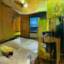

In [7]:
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline_output = image_pipe()
pipeline_output.images[0]

In [8]:
image_pipe.save_pretrained("diffusion_models/diffusion_one")

  0%|          | 0/1000 [00:00<?, ?it/s]

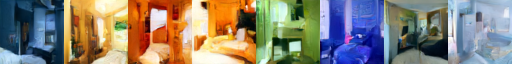

In [9]:
images = image_pipe(batch_size=8).images
make_grid(images)

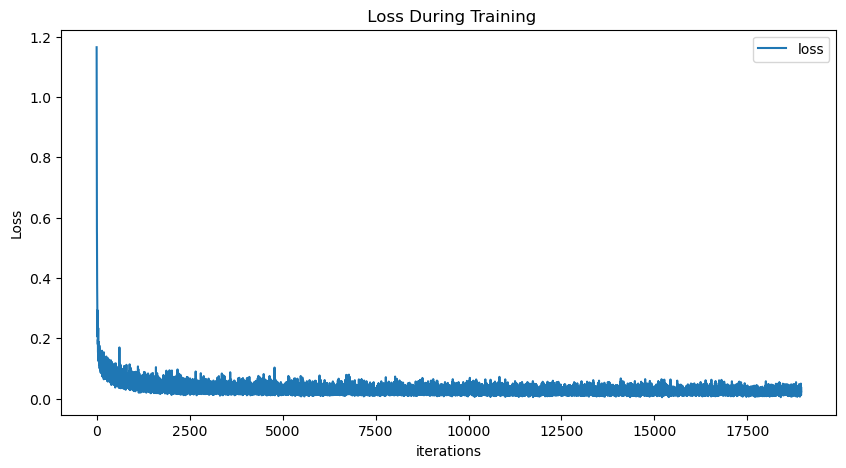

In [10]:
plt.figure(figsize=(10,5))
plt.title(" Loss During Training")
plt.plot(losses,label="loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()